# Problem with $\Sigma_x$

In [1]:
import copy

import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import arma_generate_sample
import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import pandas as pd
from tqdm import tqdm

from ucn.models import SMCN
from src.trainer import SMCNTrainer
from src.dataset import ChunkDataset
from src.utils import plot_range, compute_cost, freq_filter, uncertainty_estimation

torch.manual_seed(28)

%load_ext autoreload
%autoreload 2

plt.rcParams.update({
    'font.size': 25,
    'figure.figsize': (25, 5)
})

## Generate noisy dataset from the model

### Paramètres à changer

Le couple $\Sigma_y = 0.05, \Sigma_x =  0.1 I_2$ donne des résultats cohérents. Lorsque l'on réduit $\Sigma_x$, on obtient un score lié à la prédiction à $t+1$ très en deça de nos attentes (voir dernière cellule du notebook). Lancer la simulation avec $\Sigma_x = 0.01 I_2$ pour s'en rendre compte.

In [2]:
# ========== PARAMETRES A CHANGER ==========
sigma_y = 0.05
sigma_x = 0.1 # Passer à 0.01 pour rendre compte du problème
# ========== PARAMETRES A CHANGER ==========

### Sample dataset

In [3]:
d_in = 3
d_emb = 2
d_out = 1
N = 200

model = SMCN(d_in, d_emb, d_out, n_particles=1)


# Sets the range of a few parameters
model._f._linear.weight.data = torch.randn(d_out, d_emb) * 0.2 + 0.8
model._g.weight_hh.data = torch.randn(d_emb, d_emb) * 0.2
model._g.weight_ih.data = torch.randn(d_emb, d_in)*0.2 + 0.8
model._sigma_x.data = torch.eye(d_emb)*sigma_x
model._sigma_y.data = torch.diag(torch.Tensor([sigma_y]))
params_simulation = copy.deepcopy(model.state_dict())

T = 50
n_samples = 100

# Generate random inputs
u = torch.randn(T, n_samples, d_in)

# Compute outputs with added noise on the hidden state with variance sigma_x
with torch.no_grad():
    y = model(u, noise=True).view((T, n_samples, d_out))

# Add noise on the observations with variance sigma_y
y = y + torch.randn(y.shape) * np.sqrt(sigma_y)

The dataset is sampled from a model defined as
$$
\begin{equation*}
        \left\{
        \begin{aligned}
                x_{t+1} & = \tanh(W_{xx} x_{t} + W_{xu} u_{t+1} + b_x) + \eta_{t+1} \\
                y_{t+1} & = W_y x_{t+1}^L + b_y + \epsilon_{t+1}                        \\
        \end{aligned}
        \right.
\end{equation*}
$$

### Plot model's prediction on a sample

Discrepency between observations and predictions are due to the added observation noise, which the traditionnal model cannot account for

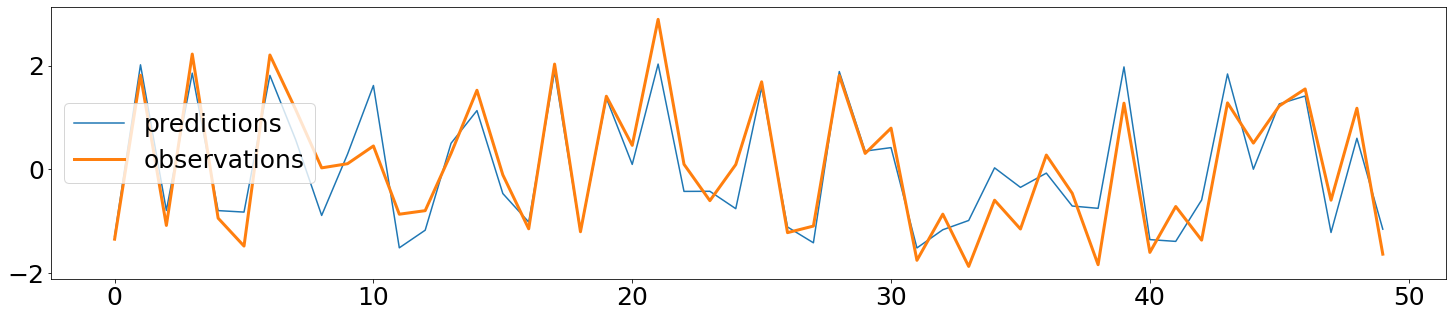

In [4]:
batch_size = 4
epochs = 50

dataset = ChunkDataset(y=y.transpose(0, 1).numpy(),
                      u=u.transpose(0, 1).numpy())
dataloader = DataLoader(dataset,
                        batch_size=batch_size,
                        num_workers=4,
                        shuffle=True
                       )

# Plot model predictions for a sample
for u, y in dataloader:
    u = u.transpose(0, 1)
    y = y.transpose(0, 1)
    break

with torch.no_grad():
    netout = model(u, noise=False)
    
netout = netout.numpy().squeeze()

plt.figure(figsize=(25, 5))
plt.plot(netout[:, 0], label='predictions')
plt.plot(y[:, 0, 0], lw=3, label='observations')
plt.legend()
plt.show()

## Evaluation

### Smoother predictions

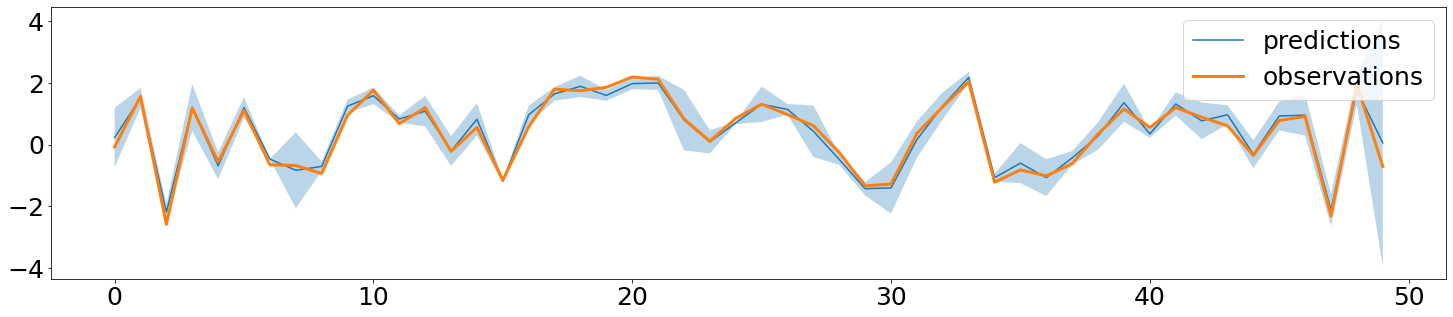

In [5]:
model.N = N

for u, y in dataloader:
    u = u.transpose(0, 1)
    y = y.transpose(0, 1)
    break

with torch.no_grad():
    netout = model(u=u,
                   y=y,
                   noise=True)

netout = model.smooth_pms(netout, model.I).numpy()

plt.figure(figsize=(25, 5))
plot_range(netout[:, 0, :, 0], label='predictions')
plt.plot(y[:, 0, 0], lw=3, label='observations')
plt.legend()

plt.show()

### Predictions at $t+1$

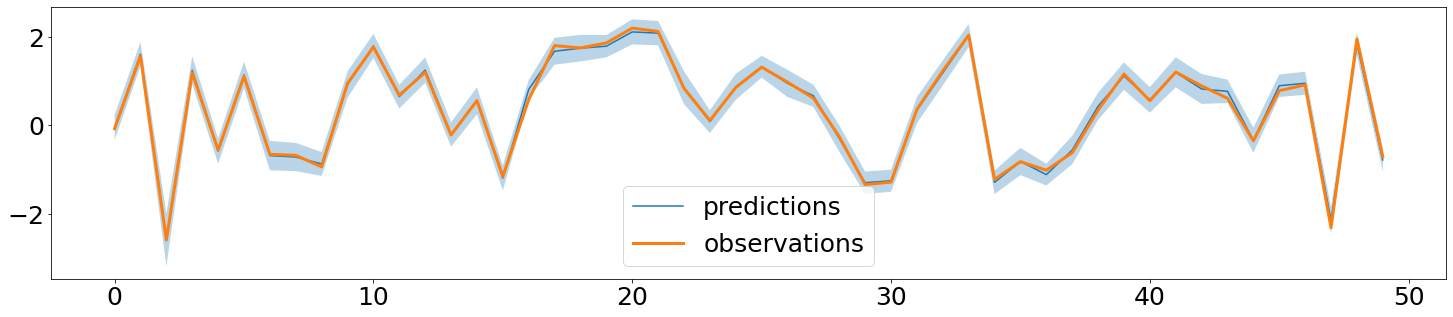

Accuracy: 98%


In [6]:
# Plot filter's prediction for each time step
with torch.no_grad():
    netout = model(u=u,
                   y=y,
                   noise=True)

netout = netout.squeeze()[:, 0]

# netout = netout + torch.randn(netout.shape) * np.sqrt(model.sigma_y.detach())-0.1
mean = netout * model.W[:, 0]
mean = mean.sum(-1)

std = netout.square() * model.W[:, 0]
std = std.sum(-1)
std = std + model.sigma_y2.detach().numpy() - np.square(mean)
std = std.flatten()

std = std.numpy()
mean = mean.numpy()

# plt.figure(figsize=(30, 8))
plt.plot(mean, label='predictions')
plt.fill_between(np.arange(len(mean)), mean - 3*std, mean + 3*std, alpha=.3)
# plt.fill_between(np.arange(len(mean)), mean - 3*std_wrong, mean + 3*std_wrong, alpha=.3)
plt.plot(y[:, 0, 0], lw=3, label='observations')
plt.legend()
plt.show()

accuracy = (((mean - 3*std) < y[:, 0, 0].numpy()) & (y[:, 0, 0].numpy() < (mean + 3*std))).sum() / mean.shape[0]
print(f'Accuracy: {accuracy*100:.0f}%')

### Plot particules with $\alpha \propto \omega$

We plot each trajectory, with a transparancy setting proportionnal to their associated weight. This graph aims at visualizing particle degenerecence.

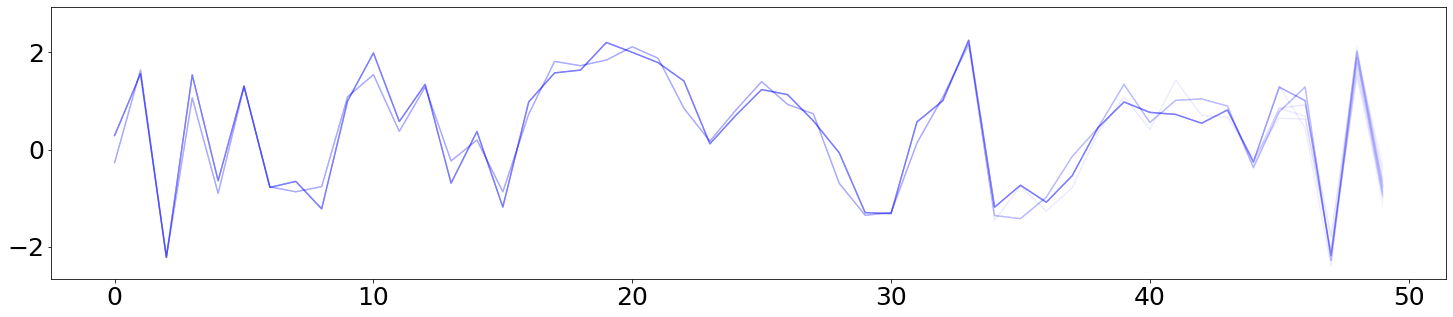

In [7]:
with torch.no_grad():
    netout = model(u=u,
                   y=y,
                   noise=True)

netout = model.smooth_pms(netout, model.I)

batch_idx = 0

netout = netout[:, batch_idx].squeeze().numpy()
w = model.w[batch_idx]
# w = torch.softmax(w, dim=0)
w = w.numpy()

# plt.plot(y[:, batch_idx].squeeze().numpy(), '--', lw=3, alpha=0.6, c='green')
for trajectory, weight in zip(netout.T, w):
    plt.plot(trajectory, alpha=weight, c='blue')

### Compute uncertainty accuracy on the entire dataset

Compute prediction at $t+1$, and compute the accuracy score based on wether the observation is inside the predicted interval. Average this score on the entire dataset. We expect a **score close to 0.98%**.

In [8]:
print(f"Uncertainty estimation: {uncertainty_estimation(model, dataloader)*100:.1f}%")

Uncertainty estimation: 98.3%
